<a href="https://colab.research.google.com/github/aidaaminian/snn-self-driving/blob/main/bproj_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install and Import

In [ ]:
!gdown --id 1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BuZNKbH3qWgedopUGwW9Gfue7oCbBTDm
To: /content/traffic-sign-yolo.zip
100% 261M/261M [00:03<00:00, 66.0MB/s]


In [ ]:
!unzip "/content/traffic-sign-yolo.zip" -d "/content/"

Archive:  /content/traffic-sign-yolo.zip
   creating: /content/traffic-sign-yolo/
  inflating: /content/traffic-sign-yolo/00000.jpg  
  inflating: /content/traffic-sign-yolo/00000.txt  
  inflating: /content/traffic-sign-yolo/00001.jpg  
  inflating: /content/traffic-sign-yolo/00001.txt  
  inflating: /content/traffic-sign-yolo/00002.jpg  
  inflating: /content/traffic-sign-yolo/00002.txt  
  inflating: /content/traffic-sign-yolo/00003.jpg  
  inflating: /content/traffic-sign-yolo/00003.txt  
  inflating: /content/traffic-sign-yolo/00004.jpg  
  inflating: /content/traffic-sign-yolo/00004.txt  
  inflating: /content/traffic-sign-yolo/00005.jpg  
  inflating: /content/traffic-sign-yolo/00005.txt  
  inflating: /content/traffic-sign-yolo/00006.jpg  
  inflating: /content/traffic-sign-yolo/00006.txt  
  inflating: /content/traffic-sign-yolo/00007.jpg  
  inflating: /content/traffic-sign-yolo/00007.txt  
  inflating: /content/traffic-sign-yolo/00008.jpg  
  inflating: /content/traffic-sign

In [ ]:
!pip install nengo
!pip install nengo-dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.3/535.3 kB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.2/286.2 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nengo-dl: filename=nengo_dl-3.6.0-py3-none-any.whl size=204190 sha256=0a5d88b774b0915442373101a651aab4f2fc033e101ee5401fb58d038b9f8f35
  Stored in directory: /root/.cache/pip/wheels/99/98/1a/c238f79c953dec26b4345dc4aa1a9b7b0b250bac1018985465
Successfully built nengo-dl


In [ ]:
%matplotlib inline
import nengo
import nengo_dl
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

### Load Data

In [ ]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
MINIBATCH_SIZE = 32

In [ ]:
dir_path = '/content/'

In [ ]:
import cv2
import glob
image_list = []
for filename in glob.glob(dir_path + 'traffic-sign-yolo/*.jpg'):
    image = cv2.imread (filename)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.resize(image,(240,240))
    image_list.append (image)

### Data Preprocessing

In [ ]:
np.array(image_list).shape

(741, 240, 240, 3)

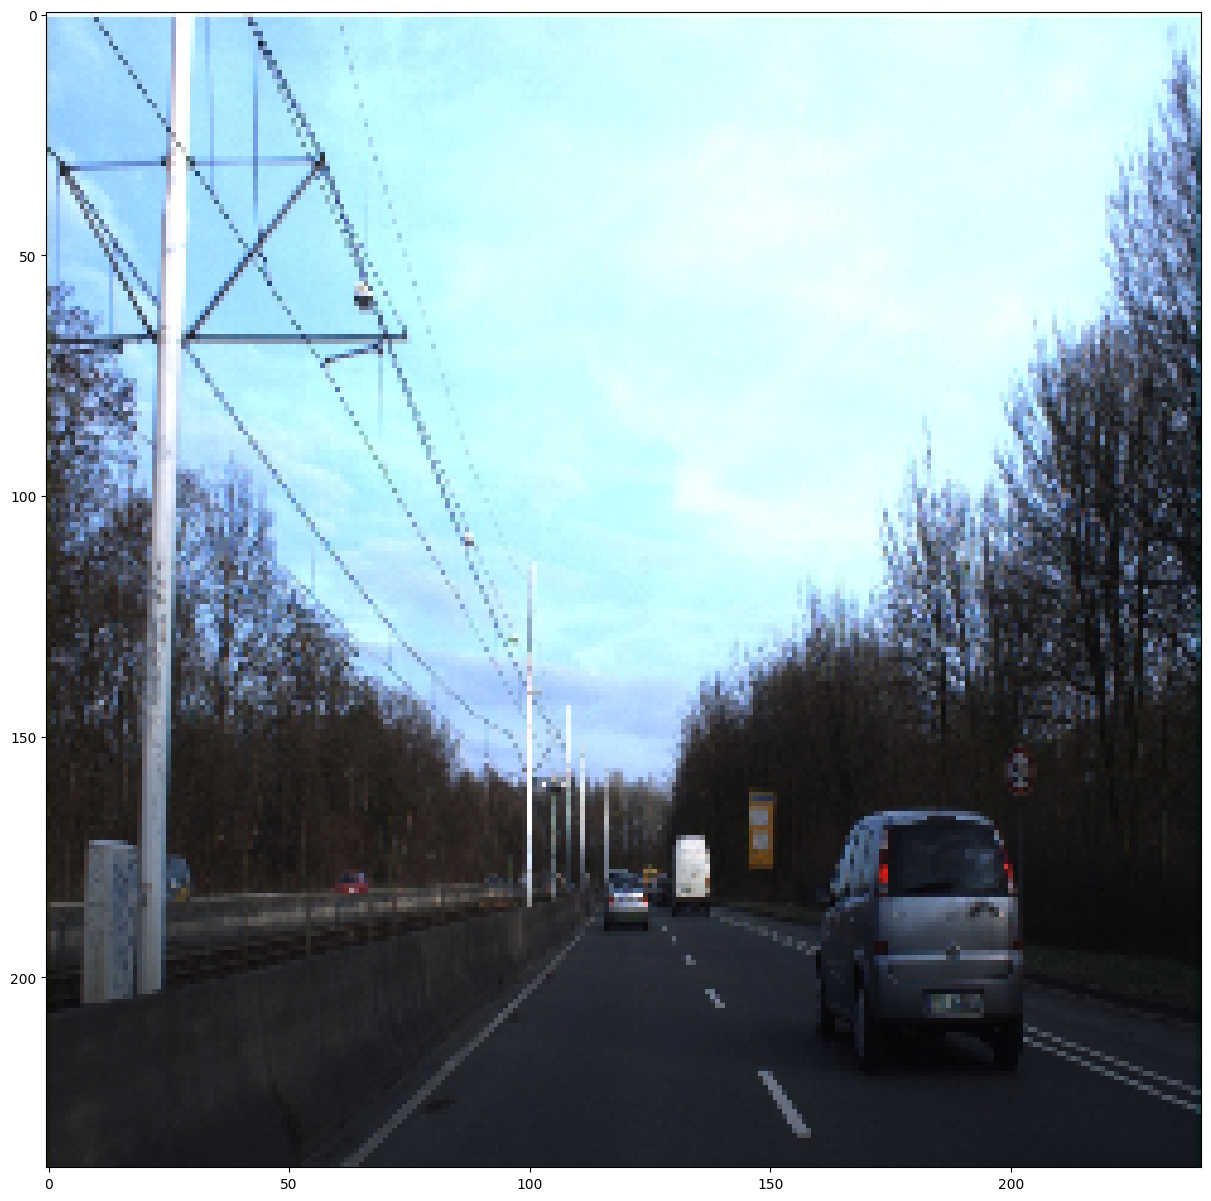

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(image_list[8])
plt.show()

In [ ]:
train_data = np.reshape(image_list, (len(image_list), -1))

In [ ]:
train_data.shape

(741, 172800)

### Autoencoder Network

In [ ]:
with nengo.Network(seed = 0) as auto_net:
    auto_net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([200])
    auto_net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    auto_net.config[nengo.Connection].synapse = None

    n_type = nengo.SpikingRectifiedLinear() 
    n_in = IMG_HEIGHT*IMG_WIDTH*3
    dim_hidden = 512

    input_node = nengo.Node(np.zeros(n_in))

    layer1 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(input_node, layer1.neurons, transform=nengo_dl.dists.Glorot())

    layer2 = nengo.Ensemble(dim_hidden, 1, neuron_type = n_type)
    nengo.Connection(layer1.neurons, layer2.neurons, transform=nengo_dl.dists.Glorot())

    outp = nengo.Ensemble(n_in, 1, neuron_type=n_type)
    nengo.Connection(layer2.neurons, outp.neurons, transform=nengo_dl.dists.Glorot())

    p_c = nengo.Probe(outp.neurons)
    p_c_filt = nengo.Probe(outp.neurons, synapse=0.01, label="out_p_filt")

In [ ]:
with nengo_dl.Simulator(network=auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.predict(np.ones((MINIBATCH_SIZE, 1, n_in)));

|############         Building network (20%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Build finished in 0:00:05                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:02                                               


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


1/1 [==============================] - 3s 3s/step


### Train Model

In [ ]:
for net_ens in auto_net.all_ensembles:
  net_ens.gain = nengo.dists.Choice([1])
  net_ens.bias = nengo.dists.Choice([0])

In [ ]:
for conn in auto_net.all_connections:
  conn.synapse = None 

In [ ]:
test_data = train_data

In [ ]:
train_data.shape

(741, 172800)

In [ ]:
train_data = train_data[:, None, :]

In [ ]:
train_data.shape

(741, 1, 172800)

In [ ]:
n_steps = 10
test_data = np.tile(test_data[:, None, :], (1, n_steps, 1))

In [ ]:
test_data.shape

(741, 10, 172800)

In [ ]:
train_data

array([[[231, 250, 252, ...,   8,  21,  30]],

       [[226, 225, 209, ...,  23,  43,  44]],

       [[244, 244, 207, ...,  19,  34,  41]],

       ...,

       [[247, 255, 254, ...,   8,  18,  21]],

       [[228, 235, 234, ...,  11,  14,  14]],

       [[235, 245, 245, ...,  11,  27,  17]]], dtype=uint8)

In [ ]:
test_data

array([[[231, 250, 252, ...,   8,  21,  30],
        [231, 250, 252, ...,   8,  21,  30],
        [231, 250, 252, ...,   8,  21,  30],
        ...,
        [231, 250, 252, ...,   8,  21,  30],
        [231, 250, 252, ...,   8,  21,  30],
        [231, 250, 252, ...,   8,  21,  30]],

       [[226, 225, 209, ...,  23,  43,  44],
        [226, 225, 209, ...,  23,  43,  44],
        [226, 225, 209, ...,  23,  43,  44],
        ...,
        [226, 225, 209, ...,  23,  43,  44],
        [226, 225, 209, ...,  23,  43,  44],
        [226, 225, 209, ...,  23,  43,  44]],

       [[244, 244, 207, ...,  19,  34,  41],
        [244, 244, 207, ...,  19,  34,  41],
        [244, 244, 207, ...,  19,  34,  41],
        ...,
        [244, 244, 207, ...,  19,  34,  41],
        [244, 244, 207, ...,  19,  34,  41],
        [244, 244, 207, ...,  19,  34,  41]],

       ...,

       [[247, 255, 254, ...,   8,  18,  21],
        [247, 255, 254, ...,   8,  18,  21],
        [247, 255, 254, ...,   8,  18,  21

In [ ]:
with nengo_dl.Simulator(auto_net, minibatch_size=MINIBATCH_SIZE) as sim:
  sim.compile(optimizer = tf.optimizers.RMSprop(1e-5), 
              loss = {p_c: tf.losses.mse,
                      p_c_filt: None}
             ) 
  sim.fit(train_data, train_data, epochs = 20)
  sim.freeze_params(auto_net)

|############         Building network (20%)                     | ETA: 0:00:00

/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:456: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fcf39d0d8d0> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fcf39d0f220> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


|#####################Building network (40%)                     | ETA: 0:00:05

/usr/local/lib/python3.10/dist-packages/nengo/builder/ensemble.py:112: NengoWarning: Specifying the gains and biases for <Ensemble (unlabeled) at 0x7fcf39d0f460> imposes a set of maximum firing rates and intercepts. Further specifying either max_rates or intercepts has no effect.
  warnings.warn(


Build finished in 0:00:10                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1892: UserWarning: Number of elements in input data (741) is not evenly divisible by Simulator.minibatch_size (32); input data will be truncated.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1736: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Probes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nengo_dl/simulator.py:1003: UserWarning: Running for one timestep, but the network contains synaptic filters (which will introduce at least a one-timestep delay); did you mean to set synapse=None?
  warnings.warn(


23/23 [==============================] - 102s 4s/step - loss: 14223.3564 - probe_loss: 14223.3564
Epoch 2/20
23/23 [==============================] - 80s 3s/step - loss: 11276.4697 - probe_loss: 11276.4697
Epoch 3/20
23/23 [==============================] - 82s 4s/step - loss: 10987.0586 - probe_loss: 10987.0586
Epoch 4/20
23/23 [==============================] - 80s 4s/step - loss: 10768.9629 - probe_loss: 10768.9629
Epoch 5/20
23/23 [==============================] - 82s 4s/step - loss: 10454.4531 - probe_loss: 10454.4531
Epoch 6/20
23/23 [==============================] - 80s 4s/step - loss: 10104.7441 - probe_loss: 10104.7441
Epoch 7/20
23/23 [==============================] - 82s 4s/step - loss: 9745.5967 - probe_loss: 9745.5967
Epoch 8/20
23/23 [==============================] - 80s 4s/step - loss: 9429.6445 - probe_loss: 9429.6445
Epoch 9/20
23/23 [==============================] - 80s 3s/step - loss: 9126.1631 - probe_loss: 9126.1631
Epoch 10/20
23/23 [=========================